# Assessing Biochemical Properties in Predicting IDPs
Simple notebook to see if any of the AAIndex features could be valuable for predicting IDPs.

First we download IDP data from DisProt:

In [1]:
import wget
import os.path as osp

# Check if disprot data is already downloaded:
if not osp.exists('disprot.tsv'):
    wget.download("https://disprot.org/api/search?release=2022_03&show_ambiguous=true&show_obsolete=false&format=tsv&namespace=all&get_consensus=false", "disprot.tsv")

Now we read AAIndex data and DisProt data (but make sure to drop regions if they refer to identical protein regions):

In [1]:
import pandas as pd
from aaindex.aaindex import aaindex

aa_index_feats = aaindex.record_codes()

disprot = pd.read_csv('disprot.tsv', sep='\t', header=0)
# Drop duplicates:
disprot = disprot.drop_duplicates(subset=['acc', 'start', 'end'])
disprot

,acc,name,organism,ncbi_taxon_id,disprot_id,region_id,start,end,term_namespace,term,ec,reference,region_sequence,confidence,obsolete
0,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,DP00003,DP00003r002,294,334,Structural state,IDPO:00076,ECO:0006220,pmid:8632448,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT,NaN,NaN
1,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,DP00003,DP00003r004,454,464,Structural state,IDPO:00076,ECO:0006220,pmid:8632448,VYRNSRAQGGG,NaN,NaN
2,P49913,Cathelicidin antimicrobial peptide,Homo sapiens,9606,DP00004,DP00004r001,134,170,Structural state,IDPO:00076,ECO:0006206,pmid:9452503,LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES,NaN,NaN
5,P03045,Antitermination protein N,Escherichia phage lambda,10710,DP00005,DP00005r001,1,107,Structural state,IDPO:00076,ECO:0006165,pmid:9659923,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,NaN,NaN
14,P03045,Antitermination protein N,Escherichia phage lambda,10710,DP00005,DP00005r012,1,22,Structural transition,IDPO:00050,ECO:0006165,pmid:9659923,MDAQTRRRERRAEKQAQWKAAN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,A0A2Z5UJ33,Nucleoprotein,Influenza A virus,382835,DP03573,DP03573r005,73,91,Structural state,IDPO:00076,ECO:0006220,pmid:17151603,ERRNKYLEEHPSAGKDPKK,NaN,NaN
10008,A0A2Z5UJ33,Nucleoprotein,Influenza A virus,382835,DP03573,DP03573r006,203,212,Structural state,IDPO:00076,ECO:0006220,pmid:17151603,DRNFWRGENG,NaN,NaN
10010,P03496,Non-structural protein 1,Influenza A virus (strain A/Puerto Rico/8/1934...,211044,DP03575,DP03575r001,204,230,Structural state,IDPO:00076,ECO:0006220,pmid:21464929,RSSNENGRPPLTPKQKREMAGTIRSEV,NaN,NaN
10011,P03496,Non-structural protein 1,Influenza A virus (strain A/Puerto Rico/8/1934...,211044,DP03575,DP03575r002,73,82,Structural state,IDPO:00076,ECO:0006220,pmid:20133840,SDEALKMTMA,NaN,NaN


Now we query UniProt to get the full sequence for each of the proteins in DisProt:

In [3]:
import requests
import time

def full_seq_from_uniprot(uniprot_id):
    url = 'https://www.uniprot.org/uniprot/' + uniprot_id + '.fasta'
    fasta = requests.get(url).text
    #time.sleep(1)
    return "".join(fasta.split('\n')[1:])

asc2seq = {}
for acc in disprot['acc'].unique():
    asc2seq[acc] = full_seq_from_uniprot(acc)

len(asc2seq)

2365

Next, we take the full sequence and strip out IDP regions, so we are only left with non-IDP regions:

In [4]:
def get_non_disordered_data(seq, regions):
    for region in sorted(regions, key=lambda x: x[0], reverse=True):
        seq = seq[:region[0]] + seq[region[1]:]
    return seq

asc2non_disordered_seq = {}
for acc in asc2seq:
    start_pos = disprot.loc[disprot['acc'] == acc, 'start'].values
    end_pos = disprot.loc[disprot['acc'] == acc, 'end'].values
    asc2non_disordered_seq[acc] = get_non_disordered_data(asc2seq[acc], list(zip(start_pos, end_pos)))

len(asc2non_disordered_seq)

2365

For each of the IDP and non-IDP regions, we calculate the average of the AAIndex features for us to do very simply analyses:

In [5]:
import numpy as np

def get_avg_feats_per_sequence(seq):
    features = np.zeros(len(aa_index_feats))
    for i, feat in enumerate(aa_index_feats):
        feat_vals = aaindex[feat]['values']
        features[i] = np.average(np.array([feat_vals[aa] for aa in seq.replace('X', '').replace('U', '').replace('Z', '')]))
    return features

prepared_data = []
for asc, ordered_seq in asc2non_disordered_seq.items():
    prepared_data.append([asc, 0, disprot.loc[disprot['acc'] == asc, 'ncbi_taxon_id'].values[0], len(ordered_seq)] + list(get_avg_feats_per_sequence(ordered_seq)))

for i, row in disprot.iterrows():
    prepared_data.append([row['acc'], 1, row['ncbi_taxon_id'], len(row['region_sequence'])] + list(get_avg_feats_per_sequence(row['region_sequence'])))

prepared_data = pd.DataFrame(prepared_data, columns=['asc', 'is_disordered', 'taxon', 'seq_length']+[f'{feat}_avg' for feat in aa_index_feats])

prepared_data.head()

E:\Users\austi\PycharmProjects\IDP-Predictor\venv\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
E:\Users\austi\PycharmProjects\IDP-Predictor\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,asc,is_disordered,taxon,seq_length,ANDN920101_avg,ARGP820101_avg,ARGP820102_avg,ARGP820103_avg,AURR980101_avg,AURR980102_avg,...,YUTK870104_avg,ZASB820101_avg,ZHOH040101_avg,ZHOH040102_avg,ZHOH040103_avg,ZIMJ680101_avg,ZIMJ680102_avg,ZIMJ680103_avg,ZIMJ680104_avg,ZIMJ680105_avg
0,P03265,0,28285,479,4.377641,0.904342,0.970501,1.018914,1.021482,1.014948,...,17.175470,-0.156228,2.749415,2.856054,12.326514,1.272234,14.983299,15.802401,6.103758,9.526305
1,P49913,0,9606,134,4.367090,0.887015,1.068507,1.090373,0.998955,0.990000,...,17.045000,-0.152060,2.848507,2.941045,12.744030,1.287090,15.187239,14.644030,6.095075,9.676866
2,P03045,0,10710,1,4.520000,1.180000,2.670000,2.960000,0.880000,1.120000,...,18.490000,-0.107000,3.630000,3.910000,15.700000,1.400000,16.250000,1.430000,5.740000,14.900000
3,P00004,0,9796,1,4.520000,1.180000,2.670000,2.960000,0.880000,1.120000,...,18.490000,-0.107000,3.630000,3.910000,15.700000,1.400000,16.250000,1.430000,5.740000,14.900000
4,P27695,0,9606,193,4.360000,0.944352,1.061969,1.103782,1.015596,1.009275,...,17.097824,-0.138544,2.995026,3.021554,13.261658,1.345751,15.096010,13.535596,6.144145,10.127979


Save the data file:

In [6]:
prepared_data.to_csv('basic_aa_features.csv', index=False)

Preprocess the data:

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

prepared_data = pd.read_csv('basic_aa_features.csv', header=0)
# Remove rows with missing values:
prepared_data = prepared_data.dropna()
# Remove rows with short sequences:
prepared_data = prepared_data[prepared_data['seq_length'] > 1]

from scipy.stats import zscore
# Shift is_disordered from 0-1 to -0.5 to 0.5:
prepared_data['is_disordered'] = prepared_data['is_disordered'] - 0.5

# Z-score the features for easier interpretation (p-values are not affected in OLS):
for col in prepared_data.columns:
    if col != 'asc' and col != 'is_disordered' and col != 'taxon':
        prepared_data[col] = zscore(prepared_data[col])

prepared_data

,asc,is_disordered,taxon,seq_length,ANDN920101_avg,ARGP820101_avg,ARGP820102_avg,ARGP820103_avg,AURR980101_avg,AURR980102_avg,...,YUTK870104_avg,ZASB820101_avg,ZHOH040101_avg,ZHOH040102_avg,ZHOH040103_avg,ZIMJ680101_avg,ZIMJ680102_avg,ZIMJ680103_avg,ZIMJ680104_avg,ZIMJ680105_avg
0,P03265,-0.5,28285,0.536091,0.278658,0.499579,0.360155,0.342056,-0.020322,-0.088246,...,-0.136091,0.256938,0.297587,0.255449,0.369188,0.440817,0.407614,0.040241,0.161141,0.290198
1,P49913,-0.5,9606,-0.113707,0.067797,0.398724,0.838054,0.711161,-0.486261,-0.750936,...,-0.255985,0.395604,0.612791,0.552614,0.667072,0.504211,0.577280,-0.159101,0.144185,0.407681
4,P27695,-0.5,9606,-0.002582,-0.073883,0.732457,0.806170,0.780424,-0.142074,-0.238943,...,-0.207443,0.845276,1.078856,0.834113,1.036383,0.754541,0.501384,-0.349849,0.240006,0.759686
6,P32774,-0.5,559292,-0.164560,-0.363376,0.366053,0.417411,0.395455,-0.719813,-1.336813,...,0.187128,0.284409,0.857446,0.776395,0.992392,0.452820,0.835924,-0.223451,-0.249148,0.311969
7,P0DMM9,-0.5,9606,0.080291,0.021401,1.096387,0.550908,0.562121,0.146255,-0.119923,...,0.207152,0.629080,1.109442,1.065316,0.939710,0.967313,1.023103,-0.209315,-0.050778,1.033841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,A0A2Z5UJ33,0.5,382835,-0.330306,0.809633,0.253737,-1.975164,-1.927782,1.647248,1.667700,...,-0.822589,-0.194273,-0.982968,-0.424526,-1.700006,0.357167,-0.280824,2.419626,1.376814,-1.648227
7007,A0A2Z5UJ33,0.5,382835,-0.347257,1.944532,-0.654877,-2.065758,-1.739113,1.210716,2.144437,...,-2.654438,0.617175,0.280361,0.335678,-0.570100,-2.261409,-1.432054,0.983043,0.278776,-1.439188
7008,P03496,0.5,211044,-0.315238,-0.325538,-0.597103,-0.780068,-0.737047,0.194158,1.029773,...,-1.525324,-0.391042,-0.984704,-0.512925,-1.280132,-0.553365,-0.333400,0.392162,1.083147,-0.672470
7009,P03496,0.5,211044,-0.347257,1.065222,-0.521005,1.947352,2.418945,-0.919690,-0.564995,...,0.911078,-0.603850,-0.199958,-0.031450,0.072020,-0.486194,-0.152530,-0.004571,-0.719057,0.121415


Run a simple linear regression on each feature to predict disordered, controlling for sequence length:

In [12]:
# Run models on each feature:
feature_pvals = []
bonferroni_correction = len(aa_index_feats)
for feat in aa_index_feats:
    # Note there didn't appear to be much of an effect from taxa
    selected_data = prepared_data[['is_disordered', 'seq_length', feat + '_avg']]
    model = ols(f"is_disordered ~ seq_length + {feat + '_avg'}", data=selected_data)
    results = model.fit()
    feature_pvals.append({'model_pval': results.f_pvalue*bonferroni_correction, 'rsq': results.rsquared, 'seq_length_p': results.pvalues[1]*bonferroni_correction, 'feat_p': results.pvalues[2]*bonferroni_correction, 'feat': feat, 'feat_name': aaindex[feat]['description']})

all_results = pd.DataFrame.from_dict(feature_pvals)
all_results.sort_values(by='model_pval', inplace=True)
all_results

,model_pval,rsq,seq_length_p,feat_p,feat,feat_name
282,0.000000e+00,0.263413,1.058986e-183,1.255193e-242,LIFS790102,Conformational preference for parallel beta-st...
317,0.000000e+00,0.271471,3.187831e-184,7.383079e-259,NADH010105,Hydropathy scale based on self-information val...
316,0.000000e+00,0.267692,1.567250e-180,3.171356e-251,NADH010104,Hydropathy scale based on self-information val...
315,0.000000e+00,0.260241,7.207224e-181,2.750292e-236,NADH010103,Hydropathy scale based on self-information val...
314,0.000000e+00,0.238950,1.951774e-183,2.063187e-194,NADH010102,Hydropathy scale based on self-information val...
...,...,...,...,...,...,...
158,7.971692e-206,0.131485,2.513856e-207,2.528125e+02,FUKS010109,Entire chain composition of amino acids in int...
179,9.698420e-206,0.131435,2.916024e-207,3.766322e+02,GEOR030106,Linker propensity from medium dataset (linker ...
161,9.817502e-206,0.131432,3.030252e-207,3.887186e+02,FUKS010112,Entire chain compositino of amino acids in nuc...
68,1.050370e-205,0.131415,4.493012e-207,4.914785e+02,CHAM830105,The number of atoms in the side chain labelled...


Perform a linear regression of the full feature set (not sure each individually):

In [13]:
full_model = ols(f"is_disordered ~ seq_length + {' + '.join([f + '_avg' for f in aa_index_feats])}", data=prepared_data)
results = full_model.fit()
feat2pval = dict(zip(aa_index_feats, results.pvalues[2:]))
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          is_disordered   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     154.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:15:21   Log-Likelihood:                -3160.0
No. Observations:                6793   AIC:                             6362.
Df Residuals:                    6772   BIC:                             6505.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1835      0.005     35.408      0.000       0.173       0.194
seq_length        -0.1391      0.005    -29.284      0.000      -0.148      -0.130
ANDN920101_avg -4.063e+10   1.22e+10     -3.322      0.001   -6.46e+10   -1.67e+10
ARGP820101_avg -4.734e+09   2.19e+09     -2.166      0.030   -9.02e+09    -4.5e+08
ARGP820102_avg  1.968e+08   1.21e+09      0.163      0.871   -2.18e+09    2.57e+09
ARGP820103_avg -1.948e+09   6.49e+08     -3.004      0.003   -3.22e+09   -6.77e+08
AURR980101_avg  3.603e+09   3.45e+09      1.043      0.297   -3.17e+09    1.04e+10
AURR980102_avg -1.301e+10   1.05e+10     -1.243      0.214   -3.35e+10    7.51e+09
AURR980103_avg -6.274e+09   7.77e+09     -0.808      0.419   -2.15e+10    8.95e+09
AURR980104_avg  4.366e+09   6.17e+09      0.708      0.479   -7.72e+09    1.65e+10
AURR980105_avg -3.561e+09   8.36e+09     -0.426      0.670      -2e+10    1.28e+10
AURR980106_avg   8.45e+09   2.51e+09      3.370      0.001    3.53e+09    1.34e+10
AURR980107_avg  6.724e+09   4.32e+09      1.555      0.120   -1.75e+09    1.52e+10
AURR980108_avg -4.344e+07   2.45e+09     -0.018      0.986   -4.84e+09    4.75e+09
AURR980109_avg  5.095e+09   1.47e+09      3.464      0.001    2.21e+09    7.98e+09
AURR980110_avg  1.228e+09   1.98e+09      0.621      0.534   -2.65e+09     5.1e+09
AURR980111_avg  2.474e+09   9.05e+08      2.734      0.006       7e+08    4.25e+09
AURR980112_avg  5.964e+09    3.4e+09      1.756      0.079   -6.94e+08    1.26e+10
AURR980113_avg  -7.24e+09   2.15e+09     -3.370      0.001   -1.15e+10   -3.03e+09
AURR980114_avg  5.044e+09   5.03e+09      1.002      0.316   -4.82e+09    1.49e+10
AURR980115_avg  6.807e+09   2.03e+09      3.352      0.001    2.83e+09    1.08e+10
AURR980116_avg  1.623e+10   7.92e+09      2.049      0.041       7e+08    3.18e+10
AURR980117_avg  6.825e+08   4.19e+09      0.163      0.870   -7.52e+09    8.89e+09
AURR980118_avg  2.675e+09   4.47e+09      0.599      0.549   -6.08e+09    1.14e+10
AURR980119_avg  6.851e+09   2.75e+09      2.495      0.013    1.47e+09    1.22e+10
AURR980120_avg -2.688e+09    3.5e+09     -0.769      0.442   -9.54e+09    4.17e+09
AVBF000101_avg  -1.12e+10   6.29e+09     -1.780      0.075   -2.35e+10    1.14e+09
AVBF000102_avg -2.432e+09   2.48e+09     -0.981      0.327    -7.3e+09    2.43e+09
AVBF000103_avg  5.765e+08   1.61e+09      0.358      0.720   -2.58e+09    3.73e+09
AVBF000104_avg  4.732e+09   3.08e+09      1.534      0.125   -1.31e+09    1.08e+10
AVBF000105_avg  2.119e+09   3.56e+09      0.595      0.552   -4.87e+09     9.1e+09
AVBF000106_avg -2.452e+09   2.94e+09     -0.834      0.404   -8.21e+09    3.31e+09
AVBF000107_avg  3.211e+09   4.71e+09      0.682      0.495   -6.02e+09    1.24e+10
AVBF000108_avg   1.32e+09   6.04e+09      0.219      0.827   -1.05e+10    1.32e+10
AVBF000109_a

Print out the results from the full model OLS:

In [14]:
for feat in sorted(feat2pval.keys(), key=lambda x: feat2pval[x]):
    print(f'{feat}: {feat2pval[feat]}')

NOZY710101: 0.0005257239349440311
DAYM780201: 0.0005259116006401891
QIAN880102: 0.0005260333863178764
CIDH920105: 0.0005263649938917811
ROBB760112: 0.0005264570079184009
NADH010104: 0.0005265076520852229
QIAN880134: 0.000526529481406763
FAUJ830101: 0.0005266399414116002
KYTJ820101: 0.0005269210422577215
CHAM830108: 0.0005272431307638232
NAKH900103: 0.0005278493329082174
DESM900101: 0.000528111294833936
SWER830101: 0.0005284046799251254
OOBM850101: 0.0005287708506259432
RADA880101: 0.0005298708186818391
SUYM030101: 0.0005300740035770184
PALJ810112: 0.000532161054390793
KOEP990102: 0.0005354341698717065
FINA910102: 0.0005354996765198802
KUMS000101: 0.0005360079122829326
QIAN880135: 0.0005363196681163523
AURR980109: 0.0005364319107754436
MEEJ810102: 0.0005368170800500088
QIAN880131: 0.0005396703685110888
PRAM820103: 0.0005412102401949171
CORJ870102: 0.0005446343749148924
BLAM930101: 0.0005451593203801761
ROSM880103: 0.0005477271857663615
NAKH900108: 0.0005498069138955117
WOLS870103: 0.000

Lets see how correlated these features are with each other.

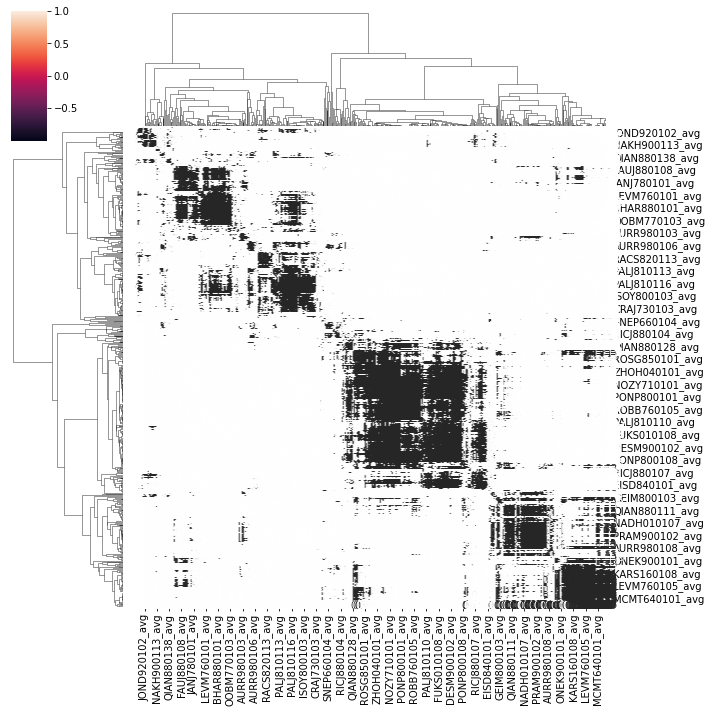

In [3]:
import seaborn as sns

# Heatmap of correlation values from features:
sns.clustermap(prepared_data[[f + "_avg" for f in aa_index_feats]].corr(), metric="correlation")

There are pretty distinct clusters let's try to reduce the number of features to a few. We can do this using VIF to identify features to drop

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
exog_vars = prepared_data[['seq_length'] + [f + "_avg" for f in aa_index_feats]]
exog_vars = sm.add_constant(exog_vars, prepend=False)
vif_df['VIF'] = [variance_inflation_factor(exog_vars.values, i+1) for i in range(len(aa_index_feats))]
vif_df['features'] = aa_index_feats
vif_df['feat_names'] = [aaindex[feat]['description'] for feat in aa_index_feats]
vif_df.sort_values(by='VIF', inplace=True)
vif_df

,VIF,features,feat_names
151,1.966569e+05,FUKS010102,Surface composition of amino acids in intracel...
358,2.946952e+05,OOBM850104,Optimized average non-bonded energy per atom (...
12,3.045954e+05,AURR980109,Normalized positional residue frequency at hel...
413,3.264372e+05,QIAN880113,Weights for alpha-helix at the window position...
7,3.493708e+05,AURR980104,Normalized positional residue frequency at hel...
...,...,...,...
550,1.967724e+07,WOLS870102,"Principal property value z2 (Wold et al., 1987)"
319,2.013645e+07,NADH010107,Hydropathy scale based on self-information val...
311,2.333905e+07,MUNV940104,Free energy in beta-strand region (Munoz-Serra...
175,2.665233e+07,GEOR030102,Linker propensity from 1-linker dataset (Georg...


Typically, a maximum threshold of 5 is used

In [5]:
selected_features = vif_df[vif_df['VIF'] < 5]
print("Remaining number of features:", selected_features.shape[0])
selected_features

Remaining number of features: 0


,VIF,features,feat_names


In [4]:
TODO:
From global VIF, keep adding the smallest and recalculate VIF until we reach a feature with a VIF > 5
Look at the correlation matrix of this reduced set of features
Check linear model to see how predictive this is

Redo everything, but directly on amino acid data points, rather than averages of sequence regions

Write script to extract all the features separately

,VIF,features,feat_names
151,1.000000,FUKS010102,Surface composition of amino acids in intracel...
358,1.498525,OOBM850104,Optimized average non-bonded energy per atom (...
12,1.548867,AURR980109,Normalized positional residue frequency at hel...
413,1.659933,QIAN880113,Weights for alpha-helix at the window position...
7,1.776550,AURR980104,Normalized positional residue frequency at hel...
...,...,...,...
550,100.058719,WOLS870102,"Principal property value z2 (Wold et al., 1987)"
319,102.393819,NADH010107,Hydropathy scale based on self-information val...
311,118.679041,MUNV940104,Free energy in beta-strand region (Munoz-Serra...
175,135.527058,GEOR030102,Linker propensity from 1-linker dataset (Georg...
